# K- Means

### Segmentar pasajeros por Edad y Tarifa

## Importar las librerias 

In [1]:
# Librerias básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Librerias de sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Cargar lo datos

In [2]:
def load_titanic():
    try:
        import seaborn as sns
        df = sns.load_dataset('titanic')
        source = "seaborn"
    except Exception:
        # Ajusta el nombre de tu CSV si es distinto
        df = pd.read_csv("Titanic-Dataset.csv")
        source = "csv_local"
    return df, source

df_raw, source = load_titanic()
print(f"Fuente de datos: {source}")
df_raw.head()

Fuente de datos: seaborn


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Limpidieza y homologación

In [3]:
df = df_raw.copy()
# Homologar nombres de columnas a minúsculas
df.columns = [c.lower() for c in df.columns]
# Revisión rápida de los datos
print("Columnas:", sorted(df.columns.tolist()))

vars_base = []
# Selección de variables numéricas disponibles
if 'age' in df.columns:
    vars_base.append('age')
if 'fare' in df.columns:
    vars_base.append('fare')

if len(vars_base) < 2:
    raise ValueError("No hay suficientes variables numéricas para el análisis.")

df_seg = df[vars_base].copy()
print("Variables seleccionadas:", vars_base)
df_seg.describe(include='all')

Columnas: ['adult_male', 'age', 'alive', 'alone', 'class', 'deck', 'embark_town', 'embarked', 'fare', 'parch', 'pclass', 'sex', 'sibsp', 'survived', 'who']
Variables seleccionadas: ['age', 'fare']


,age,fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


In [9]:
df_seg.isnull().sum()

age     177
fare      0
dtype: int64

## Imputación

In [10]:
for c in df_seg.columns:
    df_seg[c] = df_seg[c].astype(float)
    med = df_seg[c].median()
    df_seg[c] = df_seg[c].fillna(med)

print("Valores nulos por columna después de la imputación:")
print(df_seg.isnull().sum())

Valores nulos por columna después de la imputación:
age     0
fare    0
dtype: int64


## (Opcinal) Añadir variable adicionales

In [25]:
# (Opcinal) Añadir variable adicionales
extra_candidates = []
for c in ['sibsp','parch']:  # relación familiar
    if c in df.columns:
        extra_candidates.append(c)

USE_EXTRA = True # Cambiar a True para usar variables adicionales
if USE_EXTRA and extra_candidates:
    df_seg = pd.concat([df_seg, df[extra_candidates].fillna(df[extra_candidates].median())], axis=1)
    print("Variables adicionales añadidas:", extra_candidates)

df_seg.head()

Variables adicionales añadidas: ['sibsp', 'parch']


,age,fare,sibsp,parch
0,22.0,7.2500,1,0
1,38.0,71.2833,1,0
2,26.0,7.9250,0,0
3,35.0,53.1000,1,0
4,35.0,8.0500,0,0


## Escalado estándar

In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(df_seg)
X.shape

(891, 4)

## Distribución visual de Age vs Fare

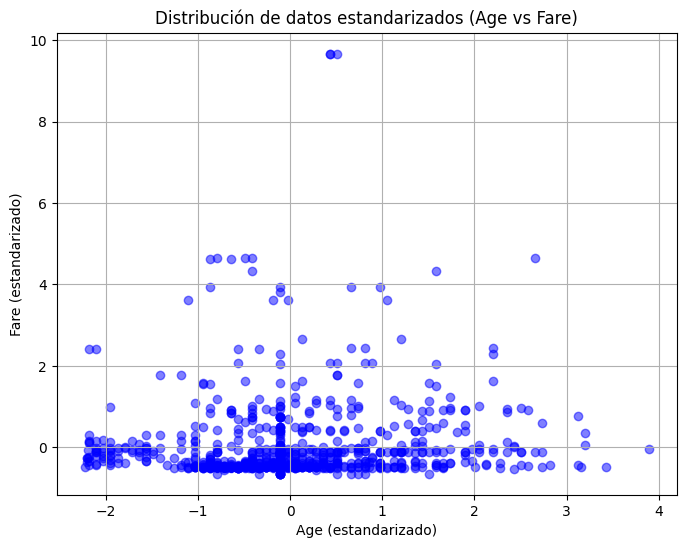

In [27]:
#Graficar datos originales age vs fare
plt.figure(figsize=(8,6)) 
plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5)
plt.title('Distribución de datos estandarizados (Age vs Fare)')
plt.xlabel('Age (estandarizado)')
plt.ylabel('Fare (estandarizado)')
plt.grid(True)
plt.show()

## Método del codo (K=?)

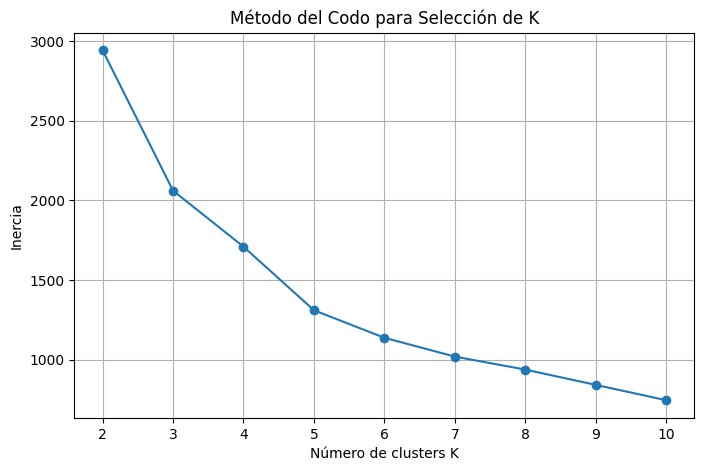

In [28]:
Ks = range(2, 11)
inertias = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_) # Suma de distancias al cuadrado dentro del cluster

plt.figure(figsize=(8, 5))
plt.plot(Ks, inertias, marker='o')
plt.title('Método del Codo para Selección de K')
plt.xlabel('Número de clusters K')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

## Silhouette score (K=?)

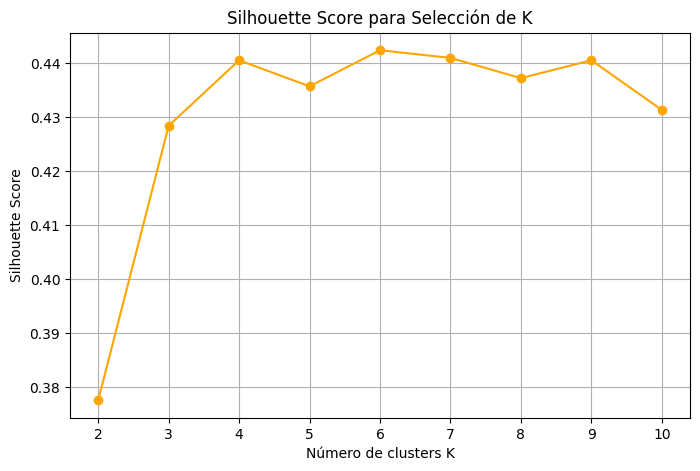

In [29]:
silhouette_scores = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(Ks, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score para Selección de K')
plt.xlabel('Número de clusters K')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [30]:
best_k = Ks[np.argmax(silhouette_scores)]
print(f"El mejor número de clusters según Silhouette Score es: {best_k}")

El mejor número de clusters según Silhouette Score es: 6


## Ejecuciión del K-Menas Final

In [34]:
#K_FINAL = best_k  # Cambiar si se desea otro valor
K_FINAL = 5
kmeans = KMeans(n_clusters=K_FINAL, random_state=42)
labels = kmeans.fit_predict(X)

df_cluster =  df_seg.copy()
df_cluster['cluster'] = labels

print("Distribución de clusters:")
print(df_cluster['cluster'].value_counts().sort_index())

Distribución de clusters:
cluster
0     46
1    166
2    586
3     58
4     35
Name: count, dtype: int64


## Visualización 2D

In [32]:
if df_seg.shape[1] == 2:
    f1, f2 = df_seg.columns[0], df_seg.columns[1]
    plt.figure(figsize=(8, 6))
    for cluster in range(K_FINAL):
        mask = (labels == cluster)
        plt.scatter(df_seg.loc[mask, f1], df_seg.loc[mask, f2], label=f'Cluster {cluster}', alpha=0.6)
    
    centrioids_scaled = kmeans.cluster_centers_
    centrioids = scaler.inverse_transform(centrioids_scaled)
    plt.scatter(centrioids[:, 0], centrioids[:, 1], s=200, c='red', marker='X', label='Centroides')    
    plt.title('Clusters Identificados')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Visualización 2D omitida porque hay más de 2 variables.")

Visualización 2D omitida porque hay más de 2 variables.


## Proyección PCA para visualizar más de 2D

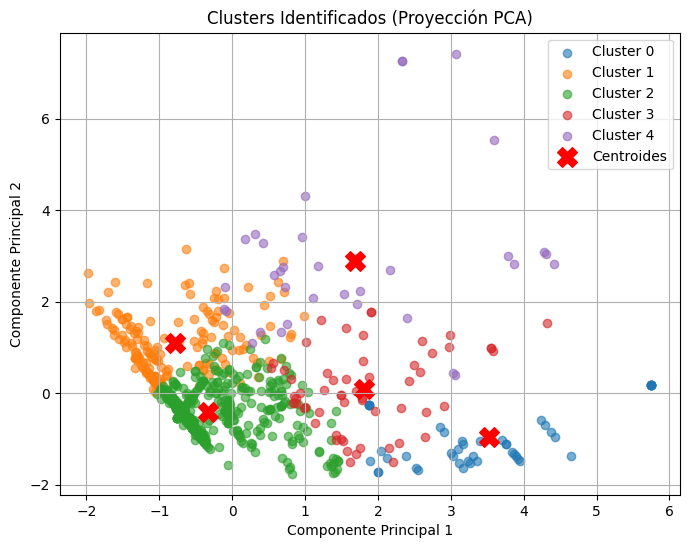

In [35]:
if df_seg.shape[1] > 2:
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    for cluster in range(K_FINAL):
        mask = (labels == cluster)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {cluster}', alpha=0.6)
    
    centrioids_scaled = kmeans.cluster_centers_
    centrioids_pca = pca.transform(centrioids_scaled)
    plt.scatter(centrioids_pca[:, 0], centrioids_pca[:, 1], s=200, c='red', marker='X', label='Centroides')    
    plt.title('Clusters Identificados (Proyección PCA)')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.grid(True)
    plt.show()